<a href="https://colab.research.google.com/github/ALejandroCh17/Tennis-Ball-Robot/blob/daniel_branch/rally_rover_tennis_ball_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tennis Ball Image Binary Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import os
import random
from hashlib import sha256
from PIL import Image
from tensorflow.keras.optimizers import RMSprop

## Exploratory Data Analysis

In [3]:
# Define the paths to the folders containing the images
folders = [
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/balls',
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/empty',
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls',
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty'
]

**Sample Image Display**

In [4]:
# Gather all image paths from the folders
all_image_paths = []
for folder in folders:
    for image_name in os.listdir(folder):
        all_image_paths.append(os.path.join(folder, image_name))

In [5]:
# Select 5 random images from the entire dataset
selected_image_paths = random.sample(all_image_paths, 5)

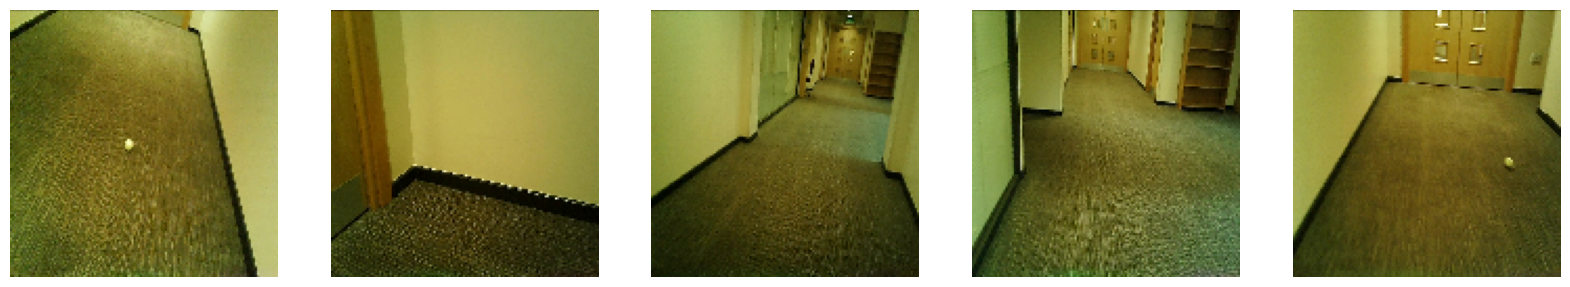

In [6]:
# Plot the selected images
plt.figure(figsize=(20, 4))
for i, img_path in enumerate(selected_image_paths):
    img = load_img(img_path, color_mode='rgb', target_size=(128, 128))  # Load and resize the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

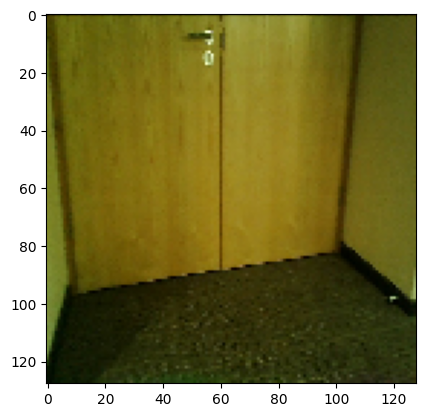

In [7]:
# Showing no ball image
img = load_img('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty/empty517.jpg', color_mode='rgb', target_size=(128,128))
img_arr = img_to_array(img)
plt.imshow(img)

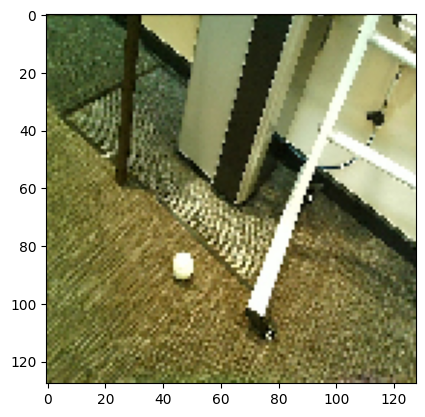

In [8]:
# Showing ball image
img = load_img('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls/ball97.jpg', color_mode='rgb', target_size=(128,128))
img_arr = img_to_array(img)
plt.imshow(img)

A comparison between both image confirms our expectation of a ball either present or not present.

**Label Distribution**

In [9]:
# Converts images to arrays for processing.
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder,filename), color_mode='rgb', target_size=(128, 128))
        img_arr = img_to_array(img)
        images.append(img_arr)
    return images

In [10]:
x_train_balls = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/balls')
x_train_empty = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/empty')
x_test_balls = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls')
x_test_empty = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty')

In [11]:
# Set the directory for each class
dir_train_balls = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/balls'
dir_train_empty = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/empty'
dir_test_balls = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls'
dir_test_empty = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty'

In [12]:
# Count the number of images in each directory
total_balls = len(os.listdir(dir_train_balls)) + len(os.listdir(dir_test_balls))
total_empty = len(os.listdir(dir_train_empty)) + len(os.listdir(dir_test_empty))

print(f'Balls: {total_balls}')
print(f'Empty: {total_empty}')

Balls: 446
Empty: 446


There are equal number of both types of images after modifying google drive file.

**Image Size**

In [13]:
def check_image_sizes(directories):
    unique_sizes = set()

    for directory in directories:
        for filename in os.listdir(directory):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
                image_path = os.path.join(directory, filename)
                with Image.open(image_path) as img:
                    unique_sizes.add(img.size)  # img.size is a tuple (width, height)

    # If there's only one unique size in the set, all images are the same size
    return len(unique_sizes) == 1, unique_sizes

In [14]:
# Use the function and print the result
all_same_size, unique_sizes = check_image_sizes(folders)
print(f"All images across all folders are the same size: {all_same_size}")
if not all_same_size:
    print(f"Unique image sizes found across all folders: {unique_sizes}")

All images across all folders are the same size: True


## Data Preprocessing

**Removing Duplicates**

In [15]:
# Concatenating no-ball and yes-ball sets together
y_train = np.concatenate( ( np.ones(len(x_train_balls)), np.zeros(len(x_train_empty))) )
x_train = np.concatenate( (np.array(x_train_balls), np.array(x_train_empty) ) )
y_test = np.concatenate( (np.ones(len(x_test_balls)), np.zeros(len(x_test_empty))) )
x_test = np.concatenate( (np.array(x_test_balls), np.array(x_test_empty) ) )

In [16]:
# Combine the datasets
x_combined = np.concatenate((x_train, x_test))
y_combined = np.concatenate((y_train, y_test))

In [17]:
print(f'Total: {len(x_combined)}')

Total: 892


892 total images in dataset before removing duplicates

In [18]:
# Flatten the image data
flattened_images = [image.flatten() for image in x_combined]

# Hash the flattened data
hashes = [sha256(image.data.tobytes()).hexdigest() for image in flattened_images]

# Identify and remove duplicates
unique_hashes = set()
unique_images = []

for i, hash_val in enumerate(hashes):
    if hash_val not in unique_hashes:
        unique_hashes.add(hash_val)
        unique_images.append(x_combined[i])

# unique_images now contains only unique images
x_combined = np.array(unique_images)

In [19]:
print(f'Total: {len(x_combined)}')

Total: 892


892 images after. Data already had all unique images

## Data Split

In [20]:
# Shuffle the combined dataset
randomize_combined = np.arange(len(y_combined))
np.random.shuffle(randomize_combined)
x_combined = x_combined[randomize_combined]
y_combined = y_combined[randomize_combined]

In [21]:
# New Split
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x_combined, y_combined, test_size=0.30, random_state=42)

# Normalize the pixel values if you haven't done it before
x_train_new = x_train_new / 255
x_test_new = x_test_new / 255

In [22]:
# Display the shapes of the resulting datasets
print("X_train shape:", x_train_new.shape)
print("X_test shape:", x_test_new.shape)
print("y_train shape:", y_train_new.shape)
print("y_test shape:", y_test_new.shape)

X_train shape: (624, 128, 128, 3)
X_test shape: (268, 128, 128, 3)
y_train shape: (624,)
y_test shape: (268,)


In [23]:
x_train_new[400:405]

array([[[[0.6039216 , 0.60784316, 0.38431373],
         [0.5647059 , 0.58431375, 0.3647059 ],
         [0.5764706 , 0.5764706 , 0.37254903],
         ...,
         [0.3372549 , 0.3529412 , 0.15686275],
         [0.48235294, 0.49411765, 0.2784314 ],
         [0.4392157 , 0.45490196, 0.22352941]],

        [[0.7764706 , 0.79607844, 0.43529412],
         [0.75686276, 0.78039217, 0.42745098],
         [0.76862746, 0.78039217, 0.43137255],
         ...,
         [0.5568628 , 0.5803922 , 0.34509805],
         [0.5764706 , 0.60784316, 0.32156864],
         [0.5137255 , 0.54901963, 0.3019608 ]],

        [[0.70980394, 0.8039216 , 0.42745098],
         [0.74509805, 0.8039216 , 0.44705883],
         [0.77254903, 0.80784315, 0.45882353],
         ...,
         [0.56078434, 0.6117647 , 0.32941177],
         [0.5647059 , 0.6       , 0.3372549 ],
         [0.57254905, 0.5921569 , 0.34117648]],

        ...,

        [[0.23921569, 0.29803923, 0.07450981],
         [0.3137255 , 0.35686275, 0.04705882]

In [24]:
y_train_new[400:405]

array([1., 1., 0., 0., 1.])

## Model Development

In [25]:
import tensorflow as tf

class SaveBeforeIncreaseCallback(tf.keras.callbacks.Callback):
    def __init__(self, save_path):
        super(SaveBeforeIncreaseCallback, self).__init__()
        self.save_path = save_path
        self.best_val_accuracy = float('inf')  # Initialize with infinity
        self.last_val_accuracy = 0.0
        self.improved = False

    def on_epoch_end(self, epoch, logs=None):
        # Extract the current validation accuracy from the logs
        current_val_accuracy = logs.get('val_accuracy')

        # If current validation accuracy is less than the best, update the best and set improved flag
        if current_val_accuracy < self.best_val_accuracy:
            self.best_val_accuracy = current_val_accuracy
            self.improved = True

        # If it was improved previously but now increased, save the model
        elif current_val_accuracy > self.last_val_accuracy and self.improved:
            print(f"Saving model from epoch {epoch} before validation accuracy increased.")
            self.model.save(self.save_path)
            self.improved = False  # Reset the improved flag

        # Update the last_val_accuracy for the next epoch comparison
        self.last_val_accuracy = current_val_accuracy

In [26]:
kernelSize = 3
poolingSize = 2
dropoutRate = 0.5

In [27]:
model = Sequential()

# Convolutional layer 1 (hidden)
model.add(Conv2D(16, kernel_size=kernelSize, activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size = poolingSize))
model.add(Dropout(dropoutRate))

# Convolutional layer 2 (hidden)
model.add(Conv2D(32, kernel_size=kernelSize, activation='relu'))
model.add(MaxPooling2D(pool_size = poolingSize))
model.add(Dropout(dropoutRate))

# Convolutional layer 3 (hidden)
model.add(Conv2D(64, kernel_size=kernelSize, activation='relu'))
model.add(MaxPooling2D(pool_size = poolingSize))
model.add(Dropout(dropoutRate))

# Convolutional layer 3 (hidden)
model.add(Conv2D(128, kernel_size=kernelSize, activation='relu'))
model.add(MaxPooling2D(pool_size = poolingSize))
model.add(Dropout(dropoutRate))

# (hidden)
model.add(Flatten())

# Dense layer (hidden)
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(dropoutRate))

# Dense layer (hidden)
model.add(Dense(units=16, activation='relu'))

# Output Layer
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

In [28]:
save_path = '/content/my_model_before_increase.h5'

# Initialize the custom callback
save_before_increase_callback = SaveBeforeIncreaseCallback(save_path=save_path)



## Training model

In [29]:
model.fit(x=x_train_new, y=y_train_new, validation_data=(x_test_new, y_test_new), epochs=10, callbacks=[save_before_increase_callback])

Epoch 1/10
20/20 [==============================] - 5s 181ms/step - loss: 0.7259 - accuracy: 0.4760 - val_loss: 0.6934 - val_accuracy: 0.4813
Epoch 2/10
20/20 [==============================] - 3s 154ms/step - loss: 0.6944 - accuracy: 0.5272 - val_loss: 0.6931 - val_accuracy: 0.4701
Epoch 3/10
20/20 [==============================] - 3s 172ms/step - loss: 0.6943 - accuracy: 0.4920 - val_loss: 0.6934 - val_accuracy: 0.4813
Epoch 4/10
 1/20 [>.............................] - ETA: 2s - loss: 0.6959 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 3s 168ms/step - loss: 0.6941 - accuracy: 0.5192 - val_loss: 0.6926 - val_accuracy: 0.5224
Epoch 5/10
20/20 [==============================] - 3s 155ms/step - loss: 0.6859 - accuracy: 0.5657 - val_loss: 0.6904 - val_accuracy: 0.4888
Epoch 6/10
20/20 [==============================] - 3s 156ms/step - loss: 0.6872 - accuracy: 0.5657 - val_loss: 0.6809 - val_accuracy: 0.6381
Epoch 7/10
20/20 [==============================] - 3s 156ms/step - loss: 0.6503 - accuracy: 0.6330 - val_loss: 0.6643 - val_accuracy: 0.6231
Epoch 8/10
20/20 [==============================] - 3s 170ms/step - loss: 0.6341 - accuracy: 0.6587 - val_loss: 0.6253 - val_accuracy: 0.7015
Epoch 9/10
20/20 [==============================] - 3s 155ms/step - loss: 0.5797 - accuracy: 0.6971 - val_loss: 0.6115 - val_accuracy: 0.6903
Epoch 10/10
20/20 [==============================] - 3s 157ms/step - loss: 0.6047 - accuracy: 0.6891 - val_loss: 0.6165 - val_accuracy: 0.7052


## History

In [30]:
history = pd.DataFrame(model.history.history)
model_accuracy = history.drop(columns=['loss', 'accuracy'])

<Axes: >

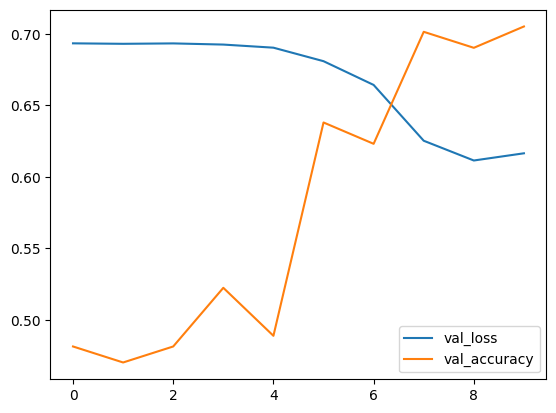

In [31]:
model_accuracy.plot()

In [32]:
#predictions = np.rint(model.predict(x_test))

In [33]:
#print( classification_report(y_test, predictions) )

In [34]:
#confusion_matrix(y_test, predictions)

In [35]:
#sample = 43
#plt.imshow(x_test[sample], cmap=plt.cm.gray_r)
#plt.title('prediction: ' + str(predictions[sample]) )

## Save model

In [36]:
#model.save('model.h5')

In [37]:
#!pwd

## Load model

In [38]:
#model = tf.keras.models.load_model('model.h5')